In [4]:
import colorsys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import networkx as nx
import numpy as np
import matplotlib.colors as mcolors

from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.dfg import algorithm as dfg_algorithm
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.util import constants
from pm4py.util import xes_constants as xes
from matplotlib.patches import FancyArrowPatch

path_to_data_folder = '/Users/alexraudvee/Desktop/TU_e/year_2/Q3Y2_Process_Mining/process_mining_data/'

In [6]:
df_2017 = pd.read_csv(f'{path_to_data_folder}clean_BPI_2017.csv')
df_2012 = pd.read_csv(f'{path_to_data_folder}clean_BPI_2012.csv')

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_76500/2501131748.py:1: DtypeWarning: Columns (16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2017 = pd.read_csv(f'{path_to_data_folder}clean_BPI_2017.csv')


In [7]:
df_2012['concept:name'].value_counts()

concept:name
W_Completeren aanvraag            48240
W_Nabellen offertes               44543
W_Nabellen incomplete dossiers    23144
W_Valideren aanvraag              20148
W_Afhandelen leads                14882
A_SUBMITTED                       13065
A_PARTLYSUBMITTED                 13058
A_DECLINED                         7617
A_PREACCEPTED                      7349
O_SENT                             7011
O_CREATED                          7011
O_SELECTED                         7011
A_ACCEPTED                         5100
A_FINALIZED                        5000
O_CANCELLED                        3642
O_SENT_BACK                        3445
A_CANCELLED                        2796
A_REGISTERED                       2239
A_APPROVED                         2238
A_ACTIVATED                        2238
O_ACCEPTED                         2237
O_DECLINED                          802
W_Beoordelen fraude                 660
W_Wijzigen contractgegevens          11
Name: count, dtype: int64

In [4]:
df_2017['concept:name'].value_counts()

concept:name
W_Validate application        209285
W_Call after offers           190891
W_Call incomplete files       168363
W_Complete application        148756
W_Handle leads                 47227
O_Created                      42957
O_Create Offer                 42952
O_Sent (mail and online)       39665
A_Validating                   38779
A_Concept                      31486
A_Create Application           31481
A_Accepted                     31480
A_Complete                     31337
O_Returned                     23282
A_Incomplete                   23036
O_Cancelled                    20878
A_Submitted                    20397
O_Accepted                     17210
A_Pending                      17206
A_Cancelled                    10421
O_Refused                       4689
A_Denied                        3750
W_Assess potential fraud        3278
O_Sent (online only)            2024
W_Shortened completion           238
W_Personal Loan collection        22
Name: count, dtype: int64

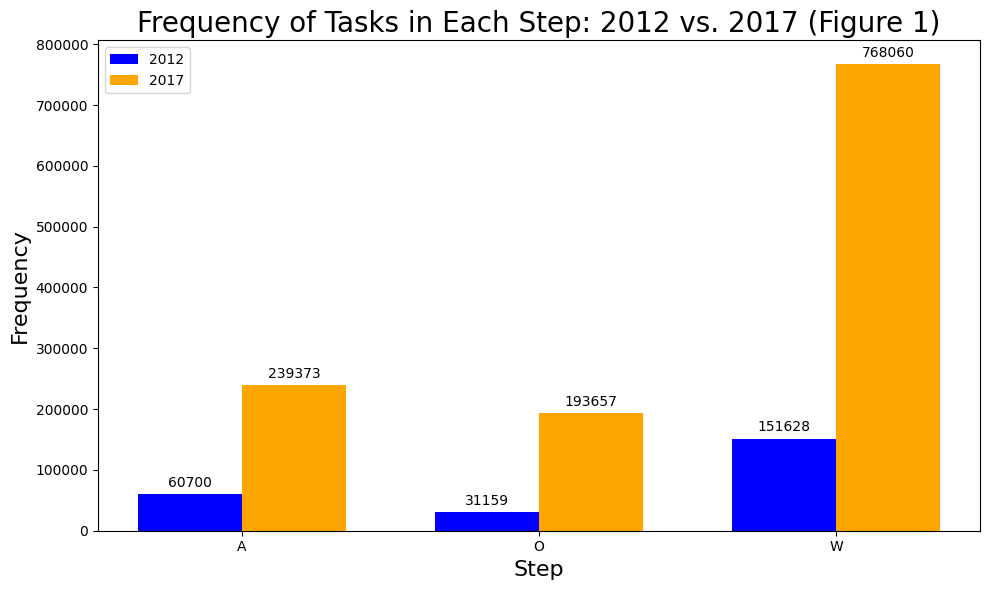

<Figure size 640x480 with 0 Axes>

In [38]:
# Extract prefixes ('W_', 'O_', 'A_')
df_2012['prefix'] = df_2012['concept:name'].str.split('_').str[0]
df_2017['prefix'] = df_2017['concept:name'].str.split('_').str[0]

# Count the occurrences of each prefix for both years
df_2012_counts = df_2012['prefix'].value_counts().sort_index()
df_2017_counts = df_2017['prefix'].value_counts().sort_index()

# Ensure both Series have the same index order
df_2012_counts = df_2012_counts.reindex(index = df_2017_counts.index)

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(df_2012_counts))

# Plotting both years' data side by side
bars1 = ax.bar(index, df_2012_counts, bar_width, label='2012', color='blue')
bars2 = ax.bar(index + bar_width, df_2017_counts, bar_width, label='2017', color='orange')

# Adding the text on the bars for 2012 and 2017
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Finalizing the plot
ax.set_title('Frequency of Tasks in Each Step: 2012 vs. 2017 (Figure 1)', size=20)
ax.set_xlabel('Step', size=16)
ax.set_ylabel('Frequency', size=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_2012_counts.index)
ax.legend()

plt.tight_layout()
plt.show()
plt.savefig("frequency_of_tasks_in_each_step_2012_vs_2017.PNG")

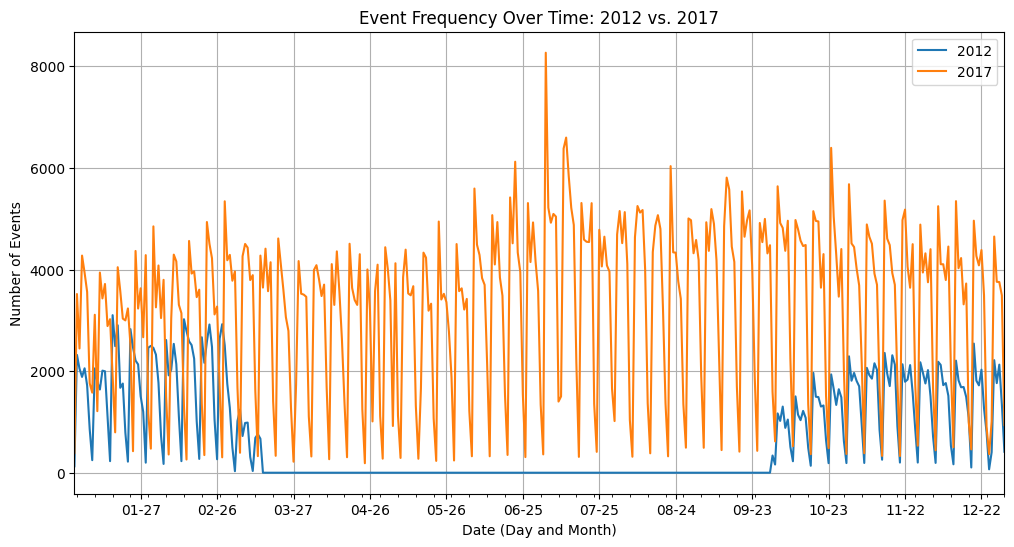

In [12]:
# Convert 'time:timestamp' to datetime
df_2012['time:timestamp'] = pd.to_datetime(df_2012['time:timestamp'])
df_2017['time:timestamp'] = pd.to_datetime(df_2017['time:timestamp'])

baseline_year = 2012
df_2012['adjusted_timestamp'] = df_2012['time:timestamp'].apply(lambda dt: dt.replace(year=baseline_year))
df_2017['adjusted_timestamp'] = df_2017['time:timestamp'].apply(lambda dt: dt.replace(year=baseline_year))

# Resample to get the count of events per day for both DataFrames
events_per_day_2012 = df_2012.set_index('adjusted_timestamp').resample('D').size()
events_per_day_2017 = df_2017.set_index('adjusted_timestamp').resample('D').size()

# Plotting both on the same figure for comparison
plt.figure(figsize=(12, 6))
events_per_day_2012.plot(kind='line', label='2012')
events_per_day_2017.plot(kind='line', label='2017')  

plt.title('Event Frequency Over Time: 2012 vs. 2017')
plt.xlabel('Date (Day and Month)')
plt.ylabel('Number of Events')
plt.legend()

# Set x-axis major formatter to display only day and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust interval as needed for clarity

plt.grid(True)
plt.show()

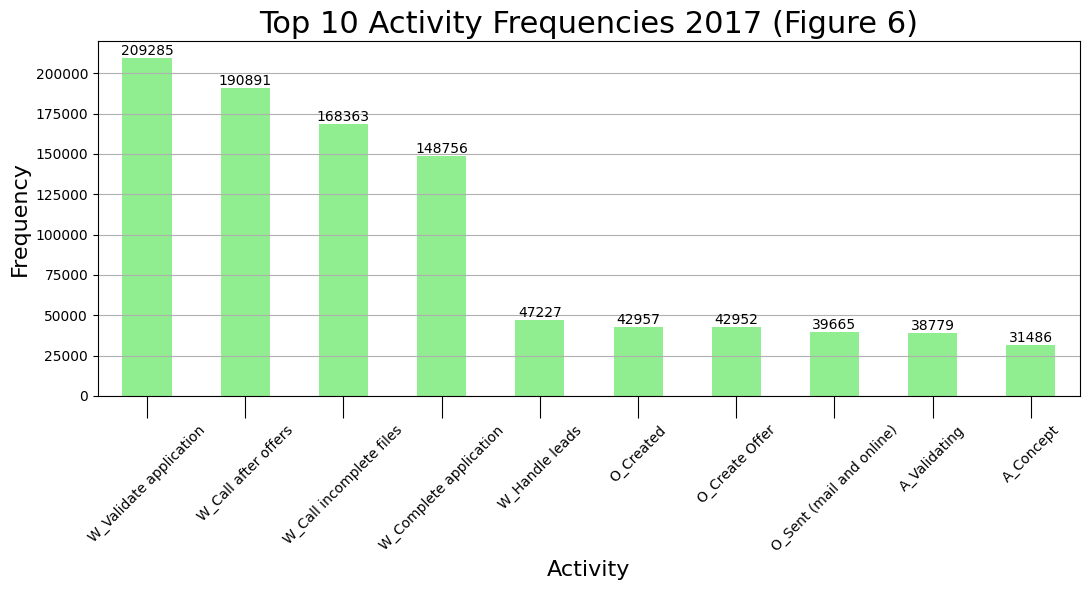

<Figure size 640x480 with 0 Axes>

In [37]:
# Count the number of occurrences of each activity
activity_frequency_2012 = df_2012['concept:name'].value_counts().head(10)  # Top 10 activities for simplicity
activity_frequency_2017 = df_2017['concept:name'].value_counts().head(10)  # Top 10 activities for simplicity

fig, axes = plt.subplots(figsize=(11, 6))

# Plot for 2012
# activity_frequency_2012.plot(kind='bar', ax=axes[0], color='skyblue')
# axes[0].set_title('Top 10 Activity Frequencies 2012')
# axes[0].set_xlabel('Activity')
# axes[0].set_ylabel('Frequency')
# axes[0].tick_params(axis='x', rotation=45)
# axes[0].grid(axis='y')

# # Adding the text on the bars for 2012
# for index, value in enumerate(activity_frequency_2012):
#     axes[0].text(index, value, str(value), ha='center', va='bottom')

# Plot for 2017
activity_frequency_2017.plot(kind='bar', ax=axes, color='lightgreen')
axes.set_title('Top 10 Activity Frequencies 2017 (Figure 6)', size=22)
axes.set_xlabel('Activity', size=16)
axes.set_ylabel('Frequency', size=16)
axes.tick_params(axis='x', rotation=45, size=16)
axes.grid(axis='y')

# Adding the text on the bars for 2017
for index, value in enumerate(activity_frequency_2017):
    axes.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()
plt.savefig('toop_10_activity_frequencies_2017.PNG')

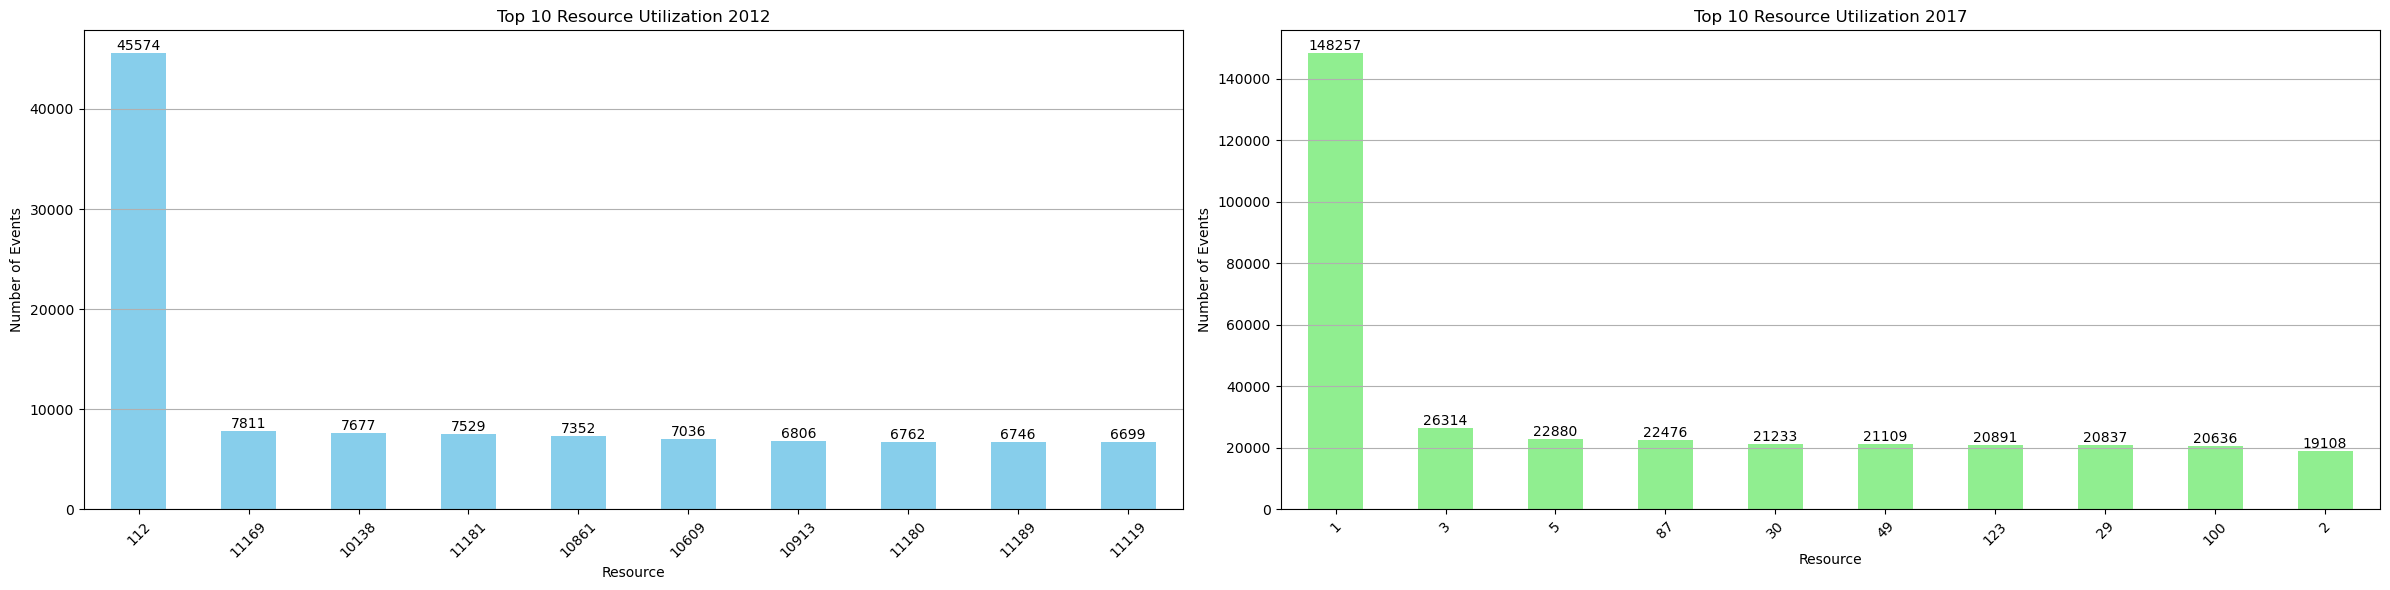

In [8]:
# Count the number of events per resource
resource_utilization_2012= df_2012['org:resource'].value_counts().head(10)  # Top 10 resources for simplicity
# Remove the 'User_' prefix from the 'org:resource' column
df_2017['org:resource'] = df_2017['org:resource'].str.replace('User_', '')
resource_utilization_2017 = df_2017['org:resource'].value_counts().head(10)  # Top 10 resources for simplicity

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot for 2012
resource_utilization_2012.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Resource Utilization 2012')
axes[0].set_xlabel('Resource')
axes[0].set_ylabel('Number of Events')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

# Adding the text on the bars for 2012
for index, value in enumerate(resource_utilization_2012):
    axes[0].text(index, value, str(value), ha='center', va='bottom')

# Plot for 2017
resource_utilization_2017.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Resource Utilization 2017')
axes[1].set_xlabel('Resource')
axes[1].set_ylabel('Number of Events')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

# Adding the text on the bars for 2017
for index, value in enumerate(resource_utilization_2017):
    axes[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

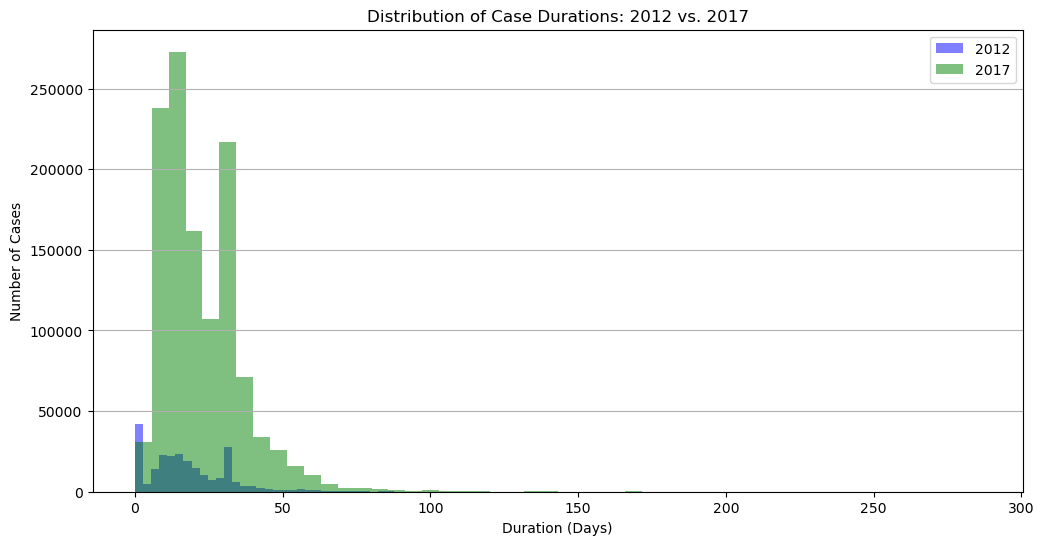

In [9]:
# Calculate case durations for 2012
df_2012['time:timestamp'] = pd.to_datetime(df_2012['time:timestamp'])
df_sorted_2012 = df_2012.sort_values(by=['case:concept:name', 'time:timestamp'])
df_sorted_2012['case_duration'] = df_sorted_2012.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.max() - x.min())
df_sorted_2012['case_duration_days'] = df_sorted_2012['case_duration'].dt.total_seconds() / (60 * 60 * 24)

# Calculate case durations for 2017
df_2017['time:timestamp'] = pd.to_datetime(df_2017['time:timestamp'])
df_sorted_2017 = df_2017.sort_values(by=['case:concept:name', 'time:timestamp'])
df_sorted_2017['case_duration'] = df_sorted_2017.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.max() - x.min())
df_sorted_2017['case_duration_days'] = df_sorted_2017['case_duration'].dt.total_seconds() / (60 * 60 * 24)

# Plotting
plt.figure(figsize=(12, 6))

# Plot histogram for 2012
plt.hist(df_sorted_2012['case_duration_days'], bins=50, alpha=0.5, label='2012', color='blue')

# Plot histogram for 2017
plt.hist(df_sorted_2017['case_duration_days'], bins=50, alpha=0.5, label='2017', color='green')

plt.title('Distribution of Case Durations: 2012 vs. 2017')
plt.xlabel('Duration (Days)')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(axis='y')
plt.show()


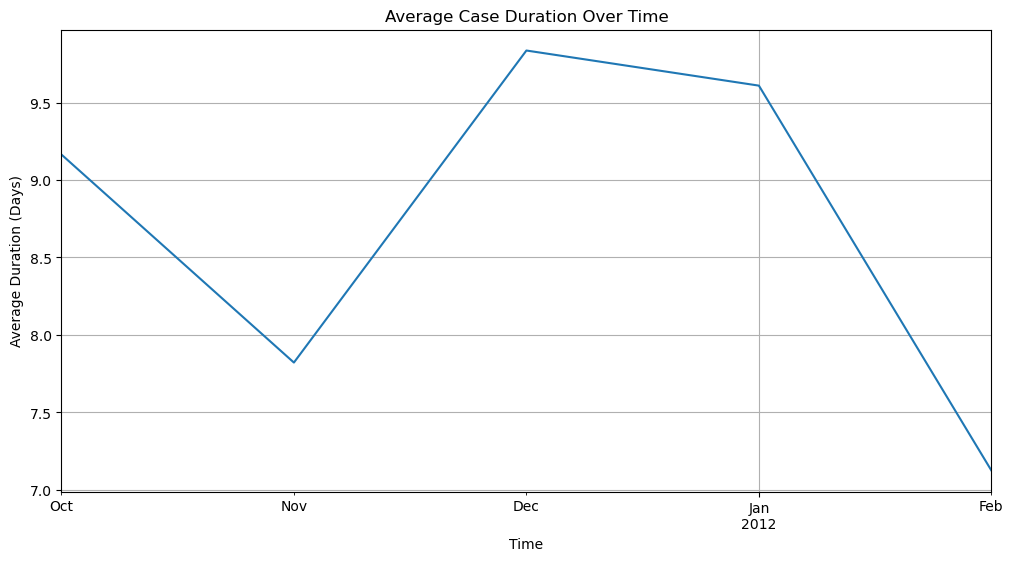

In [10]:
df_2012['time:timestamp'] = pd.to_datetime(df_2012['time:timestamp'])
df_sorted = df_2012.sort_values(by=['case:concept:name', 'time:timestamp'])

# Calculate case start and end times
case_start_end = df_sorted.groupby('case:concept:name')['time:timestamp'].agg([min, max])

# Calculate case durations in days
case_start_end['duration'] = (case_start_end['max'] - case_start_end['min']).dt.total_seconds() / (60 * 60 * 24)

# Resample to get average case duration by month
monthly_avg_duration = case_start_end.resample('M', on='min')['duration'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_avg_duration.plot()
plt.title('Average Case Duration Over Time 2012')
plt.xlabel('Time')
plt.ylabel('Average Duration (Days)')
plt.grid(True)
plt.show()

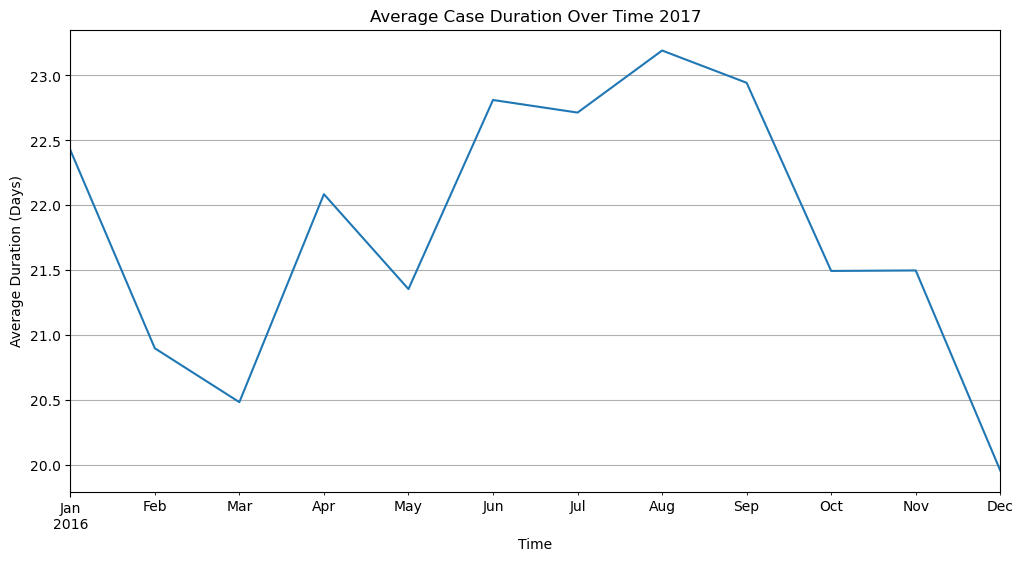

In [11]:
df_2017['time:timestamp'] = pd.to_datetime(df_2017['time:timestamp'])
df_sorted = df_2017.sort_values(by=['case:concept:name', 'time:timestamp'])

# Calculate case start and end times
case_start_end = df_sorted.groupby('case:concept:name')['time:timestamp'].agg([min, max])

# Calculate case durations in days
case_start_end['duration'] = (case_start_end['max'] - case_start_end['min']).dt.total_seconds() / (60 * 60 * 24)

# Resample to get average case duration by month
monthly_avg_duration = case_start_end.resample('M', on='min')['duration'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_avg_duration.plot()
plt.title('Average Case Duration Over Time 2017')
plt.xlabel('Time')
plt.ylabel('Average Duration (Days)')
plt.grid(True)
plt.show()

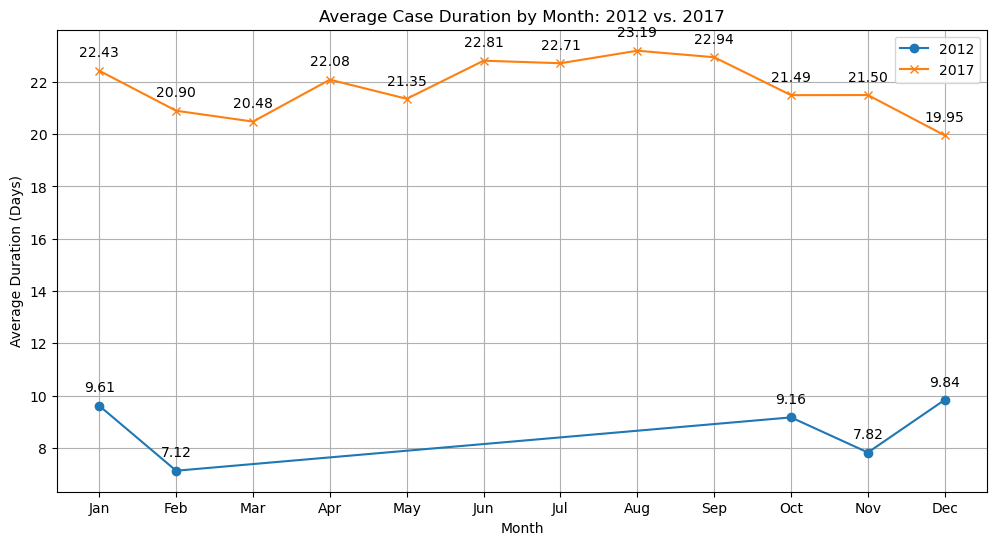

In [16]:
# Function to calculate monthly average duration
def calculate_monthly_avg_duration(df):
    df_sorted = df.sort_values(by=['case:concept:name', 'time:timestamp'])
    case_start_end = df_sorted.groupby('case:concept:name')['time:timestamp'].agg([min, max])
    case_start_end['duration'] = (case_start_end['max'] - case_start_end['min']).dt.total_seconds() / (60 * 60 * 24)
    case_start_end['month'] = case_start_end['min'].dt.month  # Extract month from start time
    monthly_avg_duration = case_start_end.groupby('month')['duration'].mean()
    return monthly_avg_duration

# Calculate monthly average duration for both years
monthly_avg_duration_2012 = calculate_monthly_avg_duration(df_2012)
monthly_avg_duration_2017 = calculate_monthly_avg_duration(df_2017)

# Plotting
plt.figure(figsize=(12, 6))
line_2012, = plt.plot(monthly_avg_duration_2012.index, monthly_avg_duration_2012.values, label='2012', marker='o')
line_2017, = plt.plot(monthly_avg_duration_2017.index, monthly_avg_duration_2017.values, label='2017', marker='x')

# Annotating each point on the 2012 line
for i, txt in enumerate(monthly_avg_duration_2012.values):
    plt.annotate(f'{txt:.2f}', (monthly_avg_duration_2012.index[i], monthly_avg_duration_2012.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Annotating each point on the 2017 line
for i, txt in enumerate(monthly_avg_duration_2017.values):
    plt.annotate(f'{txt:.2f}', (monthly_avg_duration_2017.index[i], monthly_avg_duration_2017.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Average Case Duration by Month: 2012 vs. 2017')
plt.xlabel('Month')
plt.ylabel('Average Duration (Days)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(handles=[line_2012, line_2017])
plt.grid(True)
plt.show()


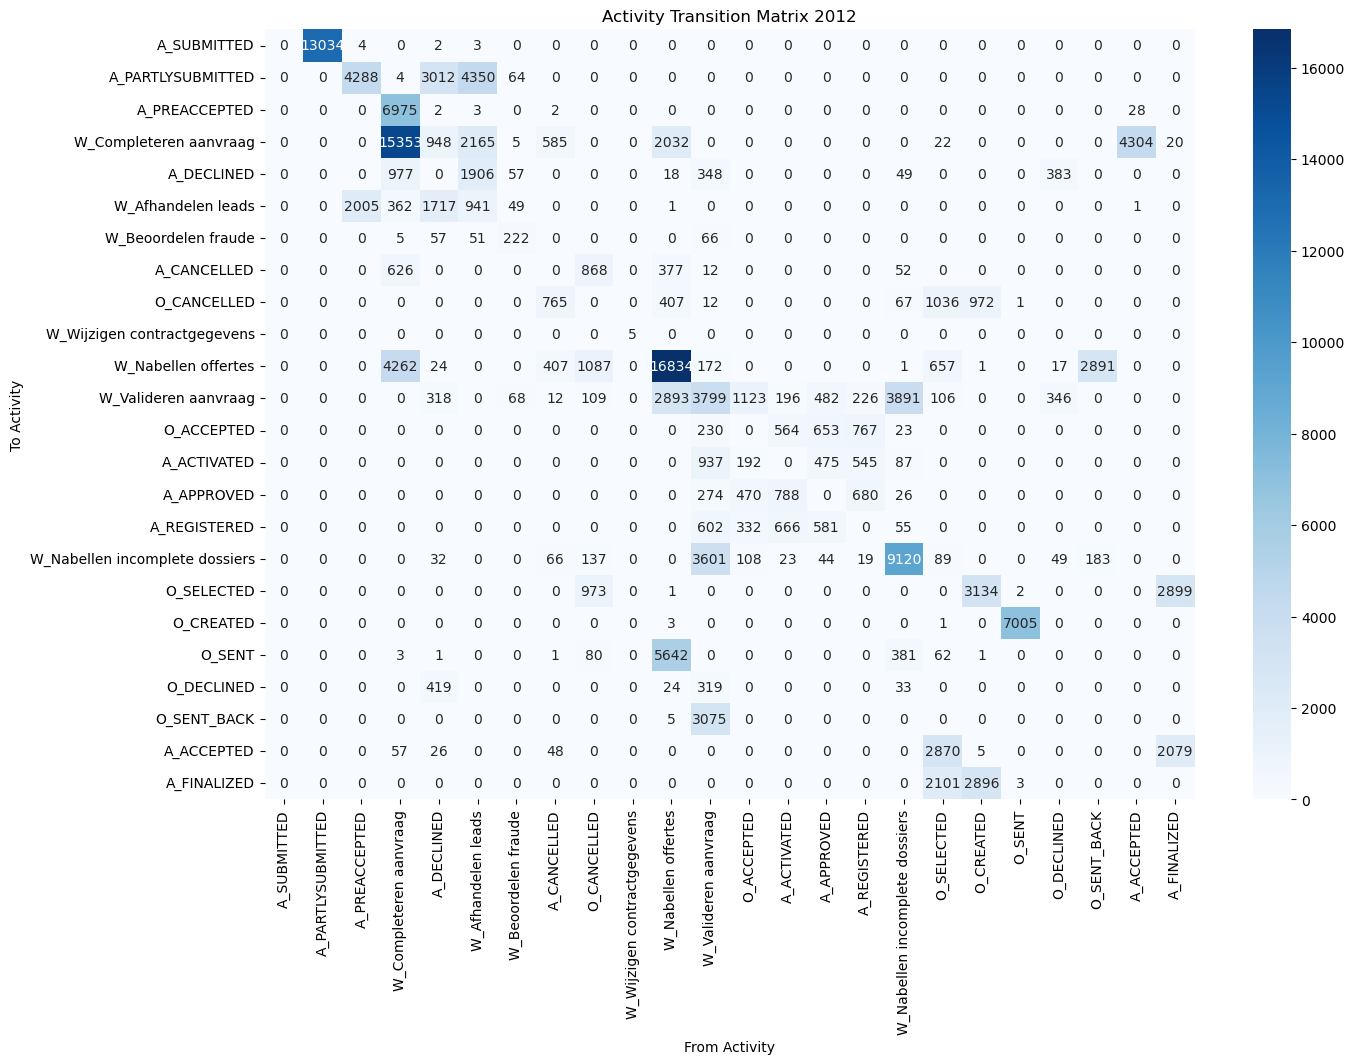

In [19]:
# Initialize the transitions DataFrame with zeros
unique_activities = df_2012['concept:name'].unique()
transitions = pd.DataFrame(0, index=unique_activities, columns=unique_activities)

# Populate the transitions DataFrame with counts
for i in range(1, len(df_2012)):
    current_activity = df_2012.iloc[i]['concept:name']
    previous_activity = df_2012.iloc[i-1]['concept:name']
    
    # Check if the previous and current activities are within the same case
    if df_2012.iloc[i]['case:concept:name'] == df_2012.iloc[i-1]['case:concept:name']:
        transitions.at[previous_activity, current_activity] += 1

# Plotting
plt.figure(figsize=(15, 10))
sns.heatmap(transitions, annot=True, fmt='d', cmap='Blues')
plt.title('Activity Transition Matrix 2012')
plt.xlabel('From Activity')
plt.ylabel('To Activity')
plt.show()

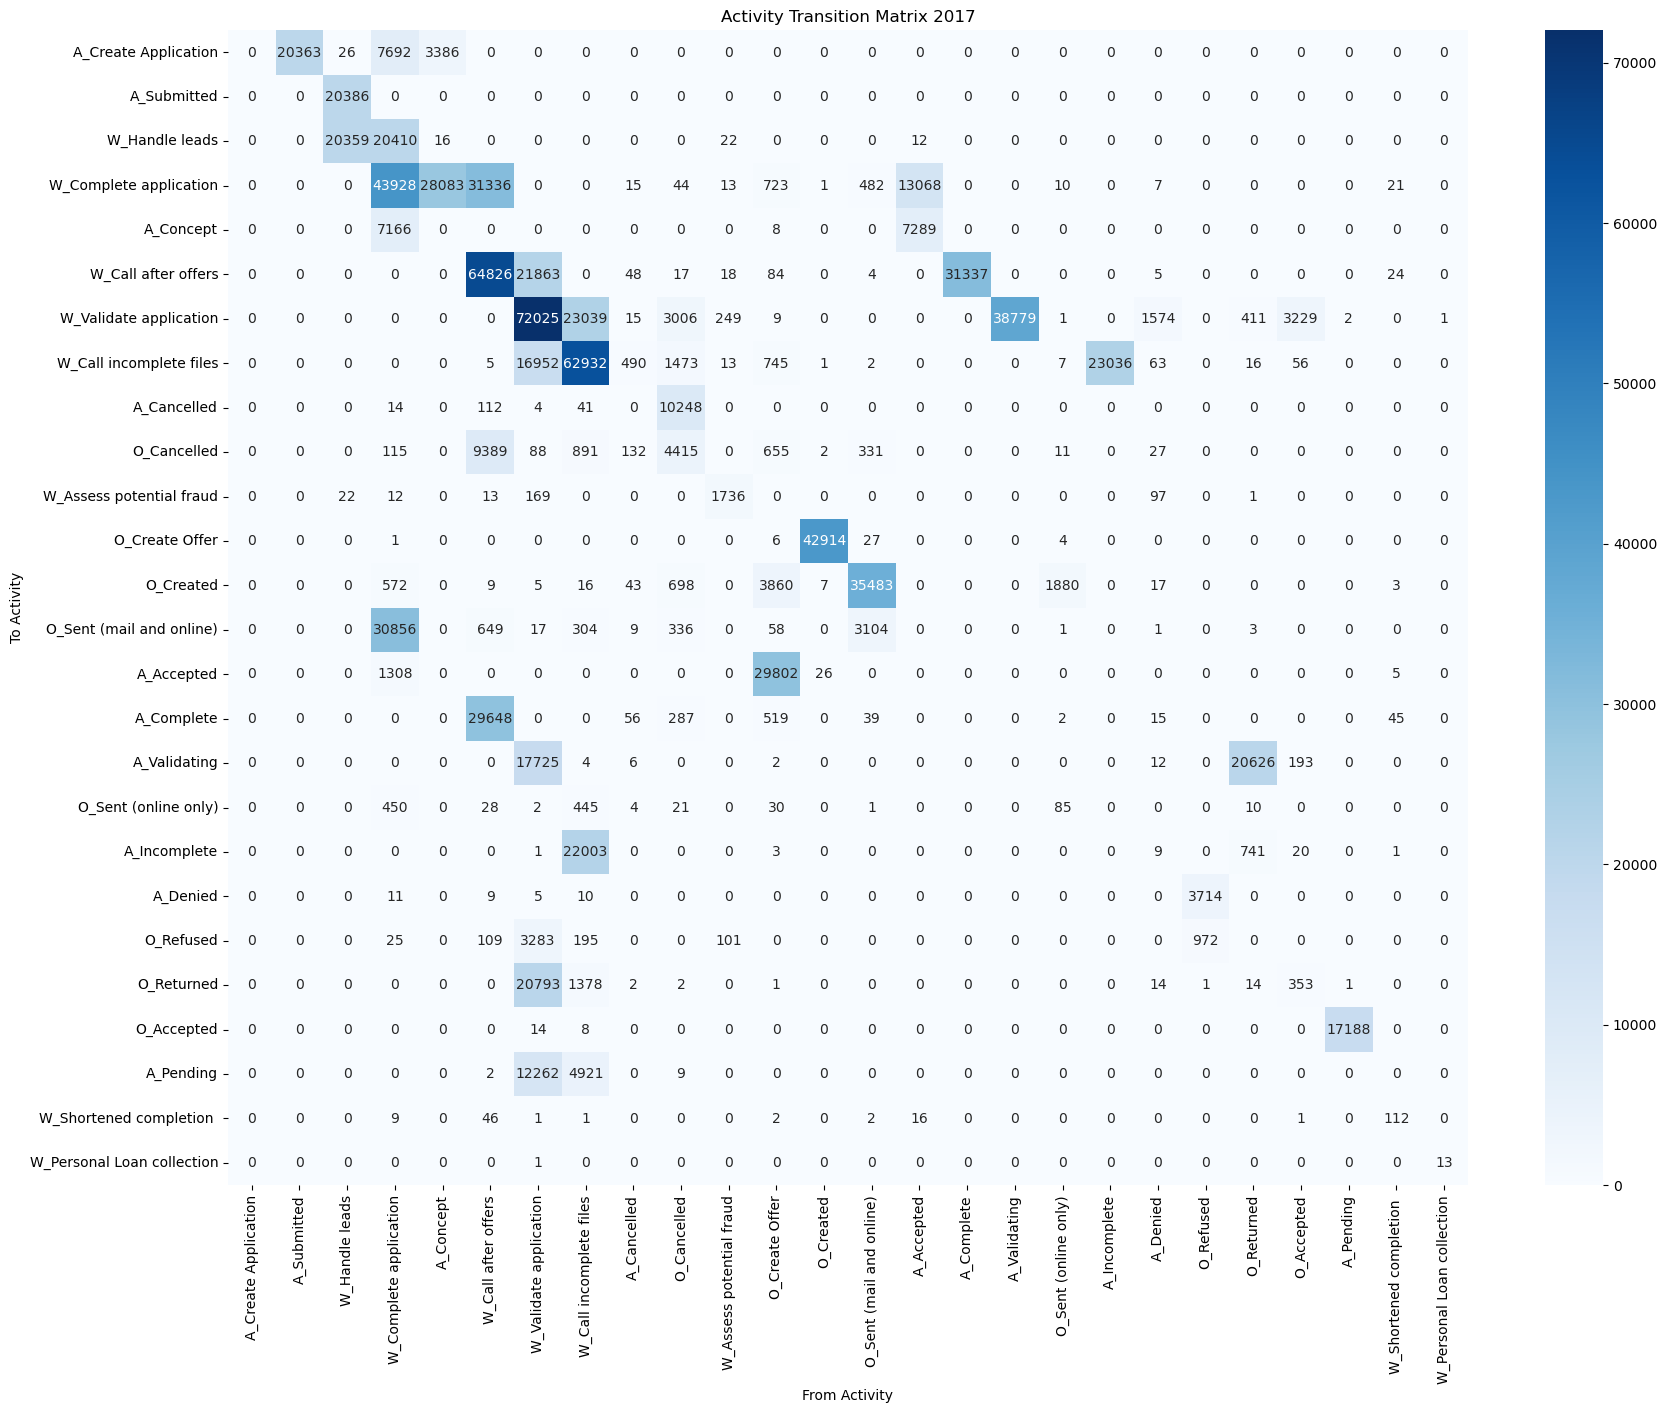

In [21]:
# Initialize the transitions DataFrame with zeros
unique_activities = df_2017['concept:name'].unique()
transitions = pd.DataFrame(0, index=unique_activities, columns=unique_activities)

# Populate the transitions DataFrame with counts
for i in range(1, len(df_2017)):
    current_activity = df_2017.iloc[i]['concept:name']
    previous_activity = df_2017.iloc[i-1]['concept:name']
    
    # Check if the previous and current activities are within the same case
    if df_2017.iloc[i]['case:concept:name'] == df_2017.iloc[i-1]['case:concept:name']:
        transitions.at[previous_activity, current_activity] += 1

# Plotting
plt.figure(figsize=(20, 15))
sns.heatmap(transitions, annot=True, fmt='d', cmap='Blues')
plt.title('Activity Transition Matrix 2017')
plt.xlabel('From Activity')
plt.ylabel('To Activity')
plt.show()

# process mining plots for 2012

In [ ]:
# Convert the DataFrame to an event log
log = dataframe_utils.convert_timestamp_columns_in_df(df_2012)
log = log_converter.apply(log)

# Discover a directly-follows graph
dfg = dfg_algorithm.apply(log)

# Visualize the graph
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


In [ ]:
# Correctly rename the columns to conform to pm4py standards
df_2012.rename(columns={'Case ID': constants.CASE_CONCEPT_NAME,
                   'Activity': xes.DEFAULT_NAME_KEY,
                   'Complete Timestamp': xes.DEFAULT_TIMESTAMP_KEY}, inplace=True)

# Convert the timestamp column to datetime
df_2012[xes.DEFAULT_TIMESTAMP_KEY] = pd.to_datetime(df_2012[xes.DEFAULT_TIMESTAMP_KEY])

# Sort the dataframe by case ID and timestamp to ensure correct sequence of events
df_2012 = dataframe_utils.convert_timestamp_columns_in_df(df_2012)
df_2012.sort_values(by=[constants.CASE_CONCEPT_NAME, xes.DEFAULT_TIMESTAMP_KEY], inplace=True)

# Convert the dataframe to an event log
log = log_converter.apply(df_2012)

# Discover a directly-follows graph
dfg = dfg_algorithm.apply(log, variant=dfg_algorithm.Variants.FREQUENCY)

# Visualize the graph
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


# process mining for 2017

In [ ]:
# Convert the DataFrame to an event log
log = dataframe_utils.convert_timestamp_columns_in_df(df_2017)
log = log_converter.apply(log)

# Discover a directly-follows graph
dfg = dfg_algorithm.apply(log)

# Visualize the graph
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


In [ ]:
# Correctly rename the columns to conform to pm4py standards
df_2017.rename(columns={'Case ID': constants.CASE_CONCEPT_NAME,
                   'Activity': xes.DEFAULT_NAME_KEY,
                   'Complete Timestamp': xes.DEFAULT_TIMESTAMP_KEY}, inplace=True)

# Convert the timestamp column to datetime
df_2017[xes.DEFAULT_TIMESTAMP_KEY] = pd.to_datetime(df_2017[xes.DEFAULT_TIMESTAMP_KEY])

# Sort the dataframe by case ID and timestamp to ensure correct sequence of events
df_2017 = dataframe_utils.convert_timestamp_columns_in_df(df_2017)
df_2017.sort_values(by=[constants.CASE_CONCEPT_NAME, xes.DEFAULT_TIMESTAMP_KEY], inplace=True)

# Convert the dataframe to an event log
log = log_converter.apply(df_2017)

# Discover a directly-follows graph
dfg = dfg_algorithm.apply(log, variant=dfg_algorithm.Variants.FREQUENCY)

# Visualize the graph
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


# network plots for 2012

 ### improved network

In [ ]:
# Sort by case_id and timestamp
df_2012.sort_values(by=['case:concept:name', 'time:timestamp'], inplace=True)

# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities
for i in range(1, len(df_2012)):
    if df_2012.iloc[i]['case:concept:name'] == df_2012.iloc[i - 1]['case:concept:name']:
        G.add_edge(df_2012.iloc[i - 1]['concept:name'], df_2012.iloc[i]['concept:name'])

def get_distinct_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        lightness = 0.5  
        saturation = 0.9  
        rgb_color = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append(rgb_color)
    return colors

# Generate distinct colors for each node
node_colors_list = get_distinct_colors(len(G.nodes()))

# Assign a unique color to each node
node_colors = {node: node_colors_list[i] for i, node in enumerate(G.nodes())}

# Create positions for the nodes in the graph
pos = nx.spring_layout(G, seed=42)  # For consistent layout

# Function to draw custom arrows for non-self-loop edges
def draw_custom_arrows(G, pos, ax, edge_list, arrow_size=15):
    for edge in edge_list:
        if edge[0] != edge[1]:  # Check if it's not a self-loop
            start, end = pos[edge[0]], pos[edge[1]]
            # Use a slightly darker shade of the node's color for the arrow
            arrow_color = colorsys.rgb_to_hsv(*node_colors[edge[0]])
            arrow_color = colorsys.hsv_to_rgb(arrow_color[0], arrow_color[1], max(arrow_color[2] * 0.8, 0))
            arrow = FancyArrowPatch(start, end, arrowstyle='-|>', color=arrow_color,
                                    mutation_scale=arrow_size, shrinkA=5, shrinkB=5, linewidth=0)
            ax.add_patch(arrow)

# Draw the graph
plt.figure(figsize=(18, 18))
ax = plt.gca()

# Draw nodes with assigned colors
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=list(node_colors.values()), alpha=0.7)

# Draw all edges in grey without arrows
nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e[0] != e[1]], width=1.5, edge_color='grey', arrows=False)

# Draw self-loop edges in red with arrows
nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e[0] == e[1]], width=1.5, edge_color='red', arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.1')

# Draw custom arrows for non-self-loop edges using a darker shade of the node's color
draw_custom_arrows(G, pos, ax, [e for e in G.edges() if e[0] != e[1]], arrow_size=25)

# Draw node labels with improved readability
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Process Map_2012")
plt.axis("off")
plt.show()


 ### improved network

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities for each case
last_activity = {}
for index, row in df_2012.iterrows():
    case_id = row['case:concept:name']
    activity = row['concept:name']
    if case_id in last_activity:
        G.add_edge(last_activity[case_id], activity)
    last_activity[case_id] = activity

# Assign a unique color to each node based on TABLEAU_COLORS
colors = list(mcolors.TABLEAU_COLORS.values())  # Using .values() to get the actual color strings
node_colors = {node: colors[i % len(colors)] for i, node in enumerate(G.nodes())}

# Prepare a list of edge colors based on the source node color
edge_colors = [node_colors[edge[0]] for edge in G.edges()]

# Calculate positions for each node
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

# Draw the graph
plt.figure(figsize=(18, 18))

# Draw nodes with assigned colors
nx.draw_networkx_nodes(G, pos, node_size=400, node_color=list(node_colors.values()), alpha=0.7)

# Draw edges with colors based on the source node
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, arrowsize=25, arrowstyle="->")

# Draw node labels with improved readability
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=10, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Network Graph of Process Activities_2012")
plt.axis("off")
plt.show()


# network plots for 2017

In [ ]:
# Sort by case_id and timestamp
df_2017.sort_values(by=['case:concept:name', 'time:timestamp'], inplace=True)

# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities
for i in range(1, len(df_2017)):
    if df_2017.iloc[i]['case:concept:name'] == df_2017.iloc[i - 1]['case:concept:name']:
        G.add_edge(df_2017.iloc[i - 1]['concept:name'], df_2017.iloc[i]['concept:name'])

# Function to generate distinct colors
def get_distinct_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        lightness = 0.5
        saturation = 0.9
        rgb_color = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append(rgb_color)
    return colors

# Generate distinct colors for each node
node_colors_list = get_distinct_colors(len(G.nodes()))

# Assign a unique color to each node
node_colors = {node: node_colors_list[i] for i, node in enumerate(G.nodes())}

# Function to draw custom arrows for non-self-loop edges
def draw_custom_arrows(G, pos, ax, edge_list, arrow_size=15):
    for edge in edge_list:
        if edge[0] != edge[1]:  # Check if it's not a self-loop
            start, end = pos[edge[0]], pos[edge[1]]
            edge_color = node_colors[edge[0]]  # Color from the source node
            arrow = FancyArrowPatch(start, end, arrowstyle='-|>', color=edge_color,
                                    mutation_scale=arrow_size, shrinkA=5, shrinkB=5, linewidth=0)
            ax.add_patch(arrow)

# Create positions for the nodes in the graph
pos = nx.spring_layout(G, seed=42)  # For consistent layout

# Draw the graph
plt.figure(figsize=(18, 18))
ax = plt.gca()

# Draw nodes with assigned colors
nx.draw_networkx_nodes(G, pos, node_size=600, node_color=list(node_colors.values()), alpha=0.7)

# Draw edges in grey without arrows
nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e[0] != e[1]], width=1.5, edge_color='grey', arrows=False)

# Draw self-loop edges in red with arrows
nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e[0] == e[1]], width=1.5, edge_color='red', arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.1')

# Draw custom arrows for non-self-loop edges using the source node's color
draw_custom_arrows(G, pos, ax, [e for e in G.edges() if e[0] != e[1]], arrow_size=25)

# Draw node labels with improved readability
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=8, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Process Map_2017")
plt.axis("off")
plt.show()


In [ ]:
# Assign a unique color to each node
colors = list(mcolors.TABLEAU_COLORS)  # This is a list of color names
node_colors = {node: colors[i % len(colors)] for i, node in enumerate(G.nodes())}

# Prepare a list of edge colors based on the source node color
edge_colors = [node_colors[edge[0]] for edge in G.edges()]

# Draw the graph
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G) 

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=list(node_colors.values()), alpha=0.7)

# Draw edges with colors based on the source node
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle="->", arrowsize=10)

# Draw node labels with improved readability
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=10, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Network Graph of Process Activities_2017")
plt.axis("off")
plt.show()


 ### nick's network 2012

In [ ]:
# Sort by case_id and timestamp
df_2012.sort_values(by=['case:concept:name', 'time:timestamp'], inplace=True)

# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities
for i in range(1, len(df_2012)):
    if df_2012.iloc[i]['case:concept:name'] == df_2012.iloc[i - 1]['case:concept:name']:
        G.add_edge(df_2012.iloc[i - 1]['concept:name'], df_2012.iloc[i]['concept:name'])

# Draw the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=400)
nx.draw_networkx_edges(G, pos, width=0.1)
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")
plt.title("Process Map")
plt.axis("off")
plt.show()

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities for each case
# Here, we'll track the last activity to create a sequence within each case
last_activity = {}

for index, row in df_2012.iterrows():
    case_id = row['case:concept:name']
    activity = row['concept:name']
    
    # Check if the current case had a previous activity
    if case_id in last_activity:
        # Add edge from last activity to current activity for the same case
        G.add_edge(last_activity[case_id], activity)
    
    # Update the last activity for the current case
    last_activity[case_id] = activity

# Use a spring layout to visualize the graph, attempting to reflect some hierarchy or sequence
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

# Drawing the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

plt.title("Network Graph of Process Activities")
plt.axis("off")  # Turn off the axis
plt.show()